# **Installing And Importing Necessary Libraries**

In [1]:
pip install pymannkendall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly,add_changepoints_to_plot

# **Dataset**

In [5]:
df = pd.read_excel("/content/CocaCola_Sales_Rawdata.xlsx")
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


# **Problem Statement**

* Forecast the CocaCola Sales data set. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

# **EDA**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [7]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [8]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [9]:
index = pd.date_range(start='1986-1-1', periods=42, freq='Q')
df["Time"] = index
df.set_index("Time", inplace=True)

In [10]:
df = df.drop(["Quarter"], axis=1)

# **Time Series**

---



In [11]:
fig = px.line(df)
fig.show()

# **Mann-Kendall Test - to detect Trend**

### **Hypothesis :**
>H0 : There is no Trend

>H1 : There is Trend

In [12]:
mk.original_test(df)

Mann_Kendall_Test(trend='increasing', h=True, p=2.177369395894857e-12, z=7.022628287809829, Tau=0.7537746806039489, s=649.0, var_s=8514.333333333334, slope=72.2794002532959, intercept=1300.6492937088012)

In [13]:
mk.original_test(df)[2]

2.177369395894857e-12

### **Conclusion :**
* The p-value is less than 0.05, hence we reject H0 and conclude that the the trend is present in the data.

# **Augmented Dickey-fuller Test - to detect Stationarity**

### **Hypothesis:**
>H0 : The data is non-stationary

>H1 : The data is stationary

In [14]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.309421
p-value: 0.996661


###**Conclusion :**

* The p-value is greater than 0.05, hence we do not reject H0 and conclude that the data is non-stationary.


# **Decomposition - to find the type of model**

* A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.




In [15]:
types = ["additive", "multiplicative"]
for i in types:
    print(f'{i} \n\n')
    seasonal_decomposition = seasonal_decompose(df, model = i , period=12)
    seasonal_decomposition_fig = seasonal_decomposition.plot()
    seasonal_decomposition_fig = plotly.tools.mpl_to_plotly(seasonal_decomposition_fig)
    seasonal_decomposition_fig.update_layout(width = 800, height = 700, title = i)
    seasonal_decomposition_fig.show()
    print("\n\n")

additive 







multiplicative 




###**Conclusion :**

* For the Additive model, the residuals have a huge standard deviation, and also show a distinct pattern that an additive model didn’t capture. On the other hand, for the multiplicative model, the residuals are now centered around 1 and have a much lower range and standard deviation. Hence, our data follows a multiplicative model

# **Finding the order of differencing**

In [16]:
data = df
for i in range(1,20):
    series = data.diff()
    series = series.dropna()
    result = adfuller(series)
    p_value = result[1]
    data = series
    if p_value < 0.05:
        print("The order of which the data becomes stationary is : ",i)
        fig = px.line(data)
        fig.show()
        break  

The order of which the data becomes stationary is :  2


###**Conclusion:**
* Here, the graph shows that at the 2nd order differencing, the data becomes stationary and the trend is also gone, but to validate our results, we shall also perform the statistical test for testing stationarity and trend.

### **1. Mann-Kendall Test to detect Trend**

#### **Hypothesis :**
>H0 : There is no Trend

>H1 : There is Trend

In [17]:
mk.original_test(data)

Mann_Kendall_Test(trend='no trend', h=False, p=0.3107545604252415, z=1.0136400067817055, Tau=0.11282051282051282, s=88.0, var_s=7366.666666666667, slope=8.580180962880451, intercept=-156.86752581596372)

In [18]:
mk.original_test(data)[2]

0.3107545604252415

###**Conclusion :**
* The p-value is more than 0.05, hence we do not reject H0 and conclude that the the trend is not present in the data.

### **2. Augmented Dickey-fuller Test for Stationarity detection**

#### **Hypothesis:**
>H0 : The data is non-stationary

>H1 : The data is stationary

In [19]:
result = adfuller(data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -27.632625
p-value: 0.000000


###**Conclusion :**

The p-value is less than 0.05, hence we reject H0 and conclude that the data is stationary.


## **ACF and PACF plots**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



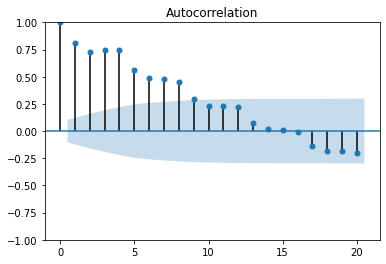

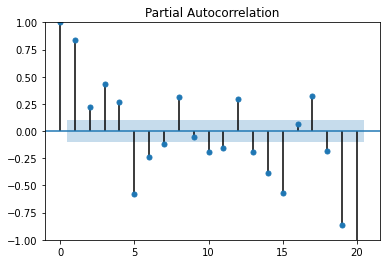

In [20]:
acf = smt.graphics.plot_acf(df, lags=20, alpha=0.5)
acf.show()
pacf = smt.graphics.plot_pacf(df, lags=20, alpha=0.5)
pacf.show()

###**Conclusion :**
1. ACF Plot :
* Here, so many points are outside the line of significance, so instead of finding the order in usual way, we shall find it in other way. Here, we are able to witness a decreasing trend in the points, hence the order will be 0.
2. PACF Plot :
* Here, almost all the points are falling outside the line of significance, hence, we shall go for other method to find the order. We shall see for the points which falls close to 1 or -1. Here, 3 points falls very close to 1 or -1. Hence the order will be 3.

## **Fitting ARIMA Model**

We got the order of ARIMA as (3,2,0)

In [21]:
model = ARIMA(df,order = (3,2,0))
model = model.fit()
print(model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   42
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -267.922
Date:                Tue, 10 Jan 2023   AIC                            543.843
Time:                        16:24:06   BIC                            550.599
Sample:                    03-31-1986   HQIC                           546.286
                         - 06-30-1996                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9851      0.045    -22.039      0.000      -1.073      -0.897
ar.L2         -1.0094      0.046    -22.062      0.000      -1.099      -0.920
ar.L3         -0.9500      0.046    -20.476      0.0

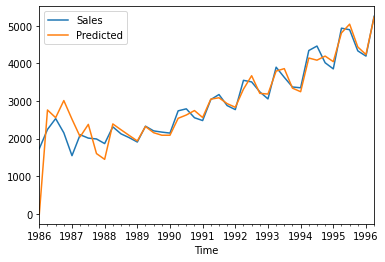

In [22]:
# making predictions 
pred = model.predict()
df.plot(legend=True)
pred.plot(label="Predicted",legend=True)
plt.show()

In [23]:
# using training and testing
train = df.Sales[:28]
test = df.Sales[28:]
print(train.shape , test.shape, df.shape)

(28,) (14,) (42, 1)


In [24]:
print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(3,2,0))
    model_fit = model.fit()
    
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    print('predicted = %f, expected = %f' % (yhat, obs))


	 ARIMA MODEL : In- Sample Forecasting 

predicted = 3239.949322, expected = 3056.000000
predicted = 3783.857832, expected = 3899.000000
predicted = 3831.717656, expected = 3629.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted = 3362.648217, expected = 3373.000000
predicted = 3290.990016, expected = 3352.000000
predicted = 4128.699752, expected = 4342.000000
predicted = 4010.654891, expected = 4461.000000


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



predicted = 4199.816638, expected = 4017.000000
predicted = 4059.928665, expected = 3854.000000
predicted = 4794.057182, expected = 4936.000000
predicted = 5063.869305, expected = 4895.000000
predicted = 4440.437326, expected = 4333.000000
predicted = 4243.307178, expected = 4194.000000
predicted = 5229.308109, expected = 5253.000000


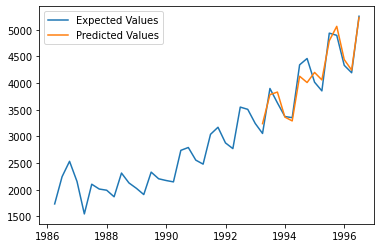

In [25]:
predictions_series = pd.Series(predictions, index = test.index)
plt.plot(df,label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [26]:
#Calculate mean squared error
print("MSE : ",mean_squared_error(test, predictions))
  
# Calculate root mean squared error
print("RMSE : ",rmse(test, predictions))

MSE :  34239.64547246103
RMSE :  185.03957812441377


### **Making Predictions for future dates**

In [27]:
index_future_dates = pd.date_range(start='1996-7-1', periods=7, freq='Q')
fut_pred = model_fit.predict(start=len(df), end=len(df)+7, typ="levels")
fut_val = fut_pred[-7:]
fut_fc = pd.DataFrame({'Sales' : fut_val},index=index_future_dates)

In [28]:
fut_fc

,Sales
1996-09-30,4608.918092
1996-12-31,4531.592801
1997-03-31,5523.067397
1997-06-30,5456.972459
1997-09-30,4888.179754
1997-12-31,4867.022191
1998-03-31,5817.043906


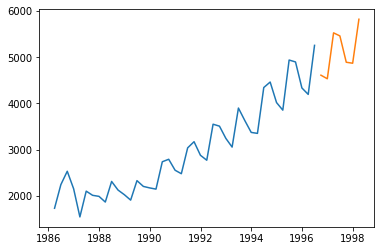

In [29]:
plt.plot(df)
plt.plot(fut_fc)
plt.show()

In [30]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_kwargs',
 '_clone_from_init_kwds',
 '_conditional_sum_squares',
 '_data_attr',
 '_fit_collinear',
 '_fit_zeros',
 '_fixed_params',
 '_fixed_params_index',
 '_forecasts_error_partial_derivatives',
 '_formula_max_endog',
 '_free_params_index',
 '_get_exog_names',
 '_get_extension_time_varying_matrices',
 '_get_index_label_loc',
 '_get_index_loc',
 '_get_index_with_final_state',
 '_get_init_kwds',
 '_get_model_names',
 '_get_prediction_index',
 '_handle_data',
 '_has_fixed_params',
 '_hessian_complex_step',
 '_hessian_finite_difference',
 '_hessian_oim',
 '_hessian_opg',
 '_hessian_par

In [31]:
# model.plot_diagnostics(figsize=(15, 12))
# plt.show()

### **Ljung-Box test:**
The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.

* H0 : independently distributed  
* H1 : not independently distribute

In [32]:
sm.stats.acorr_ljungbox(model_fit.resid, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,0.020055,0.887384


* Conclusion: 
Here p-value = 0.05 <0.87, we do not Reject Ho i.e. The data are independently distributed in the given series. 

## **Using Auto ARIMA for model building**

Here, in our data there is a serious problem of seasonality, hence we shall use SARIMAX model for forecasting. For that purpose we shall use Auto ARIMA.

In [33]:
auto_arima_model = auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=4,              # periodicity=4
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=488.648, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=491.401, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=491.202, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=489.549, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=489.438, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=491.336, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=490.586, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=490.538, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=489.597, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[4] intercept   : AIC=490.419, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,1,0)[4]          
Total fit time: 1.068 seconds
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:           

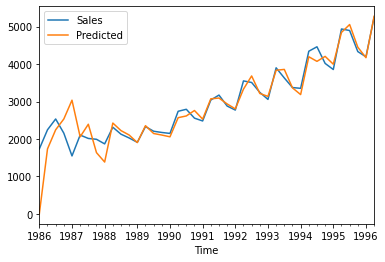

In [34]:
# making predictions
pred_auto = auto_arima_model.predict_in_sample(df)
df.plot(legend=True)
pred_auto.plot(label="Predicted",legend=True)
plt.show()

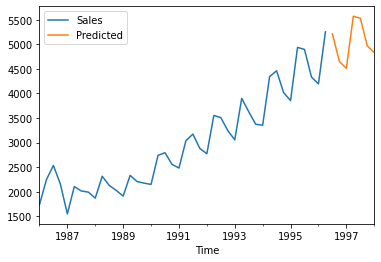

In [35]:
# making future predictions
fut_pred_auto = auto_arima_model.predict(n_periods=7)
df.plot(legend=True)
fut_pred_auto.plot(label="Predicted",legend=True)
plt.show()

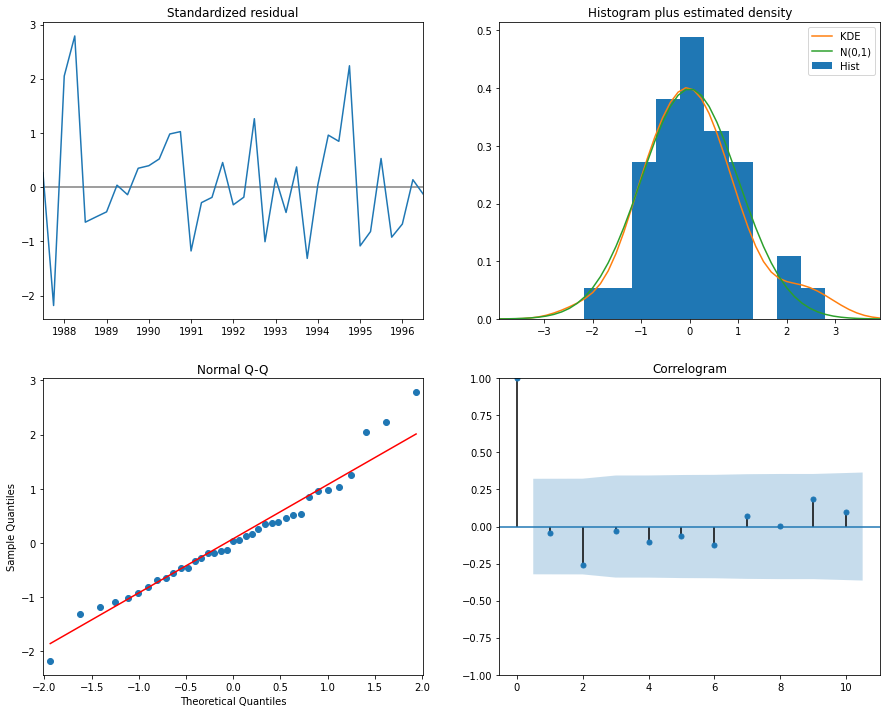

In [36]:
auto_arima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

## **Comaparing the Results from ARIMA and Auto ARIMA**

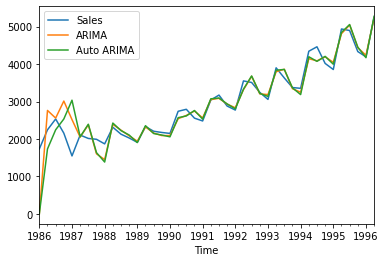

In [37]:
# comparing the in-sample predictions
df.plot(legend=True)
pred.plot(label="ARIMA",legend=True)
pred_auto.plot(label="Auto ARIMA",legend=True)
plt.show()

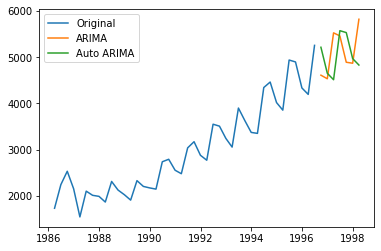

In [38]:
# comparing the future predictions
plt.plot(df, label="Original")
plt.plot(fut_fc, label="ARIMA")
plt.plot(fut_pred_auto, label="Auto ARIMA")
plt.legend()
plt.show()

## **FB Prophet** - for building the forecasting model

In [39]:
data1 = df.reset_index()

In [40]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = data1['Time']
train_dataset['y']= data1['Sales']
train_dataset.head()

,ds,y
0,1986-03-31,1734.827000
1,1986-06-30,2244.960999
2,1986-09-30,2533.804993
3,1986-12-31,2154.962997
4,1987-03-31,1547.818996


In [41]:
m = Prophet()
m.fit(train_dataset)
future = m.make_future_dataframe(periods=10, freq='Q')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuafds_t6/y2hjdvxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuafds_t6/28pqhyj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52989', 'data', 'file=/tmp/tmpuafds_t6/y2hjdvxz.json', 'init=/tmp/tmpuafds_t6/28pqhyj5.json', 'output', 'file=/tmp/tmpuafds_t6/prophet_model9107f13m/prophet_model-20230110162413.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,1986-03-31,1610.924483,1407.491947,1792.446421
1,1986-06-30,2246.517004,2057.471464,2414.998089
2,1986-09-30,2225.267396,2050.778034,2408.799884
3,1986-12-31,1877.590465,1696.125647,2061.934972
4,1987-03-31,1648.035221,1469.746331,1827.433642
5,1987-06-30,2325.731699,2153.541139,2505.604455
6,1987-09-30,2328.605331,2141.255501,2513.836821
7,1987-12-31,1962.408423,1796.398173,2141.612234
8,1988-03-31,1751.239433,1561.344804,1951.563848
9,1988-06-30,2443.067172,2275.119225,2625.520666


In [42]:
plot_plotly(m , forecast)

In [43]:
plot_components_plotly(m,forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuafds_t6/_cuexqi3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuafds_t6/6vwwygw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87436', 'data', 'file=/tmp/tmpuafds_t6/_cuexqi3.json', 'init=/tmp/tmpuafds_t6/6vwwygw4.json', 'output', 'file=/tmp/tmpuafds_t6/prophet_model74h883nf/prophet_model-20230110162416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


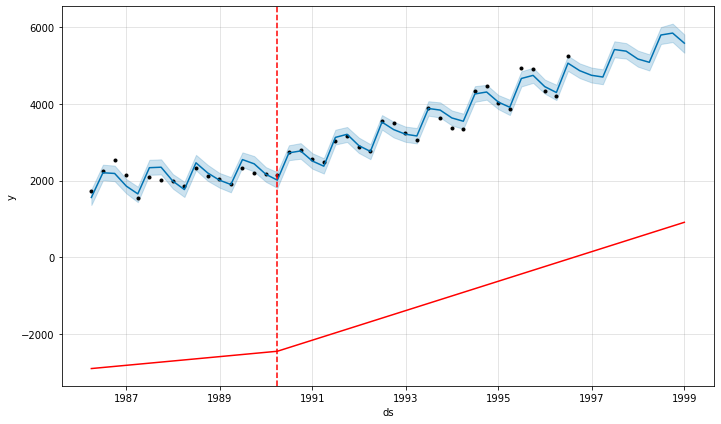

In [44]:
pro_change= Prophet(n_changepoints=4)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)